<a href="https://colab.research.google.com/github/LuccaNolasco/Linear-Regression-RESTIC/blob/main/An%C3%A1liseEngajamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Linear
Nosso objetivo é prever a taxa de engajamento de um perfil baseado em outros atributos, pois essa característica é essencial apara equipes de marketing, patrocinadores e equipes de social media dos influenciadores


Apesar do título, inicialmente não há um modelo definido, e também será decidido após a análise dos dados.

In [1]:
import kagglehub
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score,learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import scipy.stats as stats

Baixando dados do Kaggle

In [2]:
# Download latest version
path = kagglehub.dataset_download("surajjha101/top-instagram-influencers-data-cleaned")

print("Path to dataset files:", path)

100%|██████████| 5.89k/5.89k [00:00<00:00, 6.61MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/surajjha101/top-instagram-influencers-data-cleaned/versions/3


Buscando nome do dataset

In [3]:
files = os.listdir(path)
print("Arquivos no dataset:", files)

Arquivos no dataset: ['top_insta_influencers_data.csv']


Visualização do dataframe

In [4]:
dataset_path = os.path.join(path, "top_insta_influencers_data.csv")
dataframe = pd.read_csv(dataset_path)

dataframe.head()

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b,Spain
1,2,kyliejenner,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b,United States
2,3,leomessi,90,0.89k,357.3m,6.8m,1.24%,4.4m,6.0b,NaN
3,4,selenagomez,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b,United States
4,5,therock,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b,United States


## Análise exploratória

Analisaremos que são os NaNs. Percebemos que a coluna país possui 31% de NaNs. É uma porcentagem muito grande, e não podemos remover essas linhas. Removeremos então, a coluna, pois não aparence possuir grande relevância.

In [5]:
dataFrameNan = dataframe[dataframe.isna().any(axis =1)]

dataFrameNan

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
2,3,leomessi,90,0.89k,357.3m,6.8m,1.24%,4.4m,6.0b,NaN
15,16,virat.kohli,87,1.4k,211.8m,3.5m,0.96%,2.0m,4.9b,NaN
18,19,mileycyrus,89,1.2k,181.5m,1.3m,0.51%,913.6k,1.6b,NaN
20,21,katyperry,92,2.0k,170.3m,715.0k,0.16%,265.1k,1.5b,NaN
26,27,kingjames,86,2.3k,130.9m,2.1m,0.92%,1.2m,4.9b,NaN
...,...,...,...,...,...,...,...,...,...,...
179,180,sachintendulkar,76,1.0k,35.3m,800.4k,2.03%,664.5k,810.0m,NaN
182,183,lunamaya,83,4.1k,34.8m,145.4k,0.17%,58.6k,589.6m,NaN
183,184,toni.kr8s,83,0.94k,34.7m,597.2k,1.68%,533.5k,561.3m,NaN
185,186,paollaoliveirareal,84,4.6k,34.7m,367.8k,0.57%,192.3k,1.7b,NaN


In [6]:
dataframe = dataframe.drop('country', axis = 1)

Transformação de "strings numéricas para números"

In [7]:
def convert_string_to_number(value, column_name):
    """Converte strings numéricas com abreviações ou porcentagem para números reais nas colunas específicas."""
    if isinstance(value, str):
        value = value.strip().lower()

        if column_name == '60_day_eng_rate' and '%' in value:
            # Para a coluna 60_day_eng_rate, converte porcentagens
            return float(value.replace('%', '').strip()) / 100

        elif column_name in ['posts', 'followers', 'avg_likes', 'new_post_avg_like', 'total_likes']:
            # Para as colunas de posts, followers, avg_likes, new_post_avg_like, total_likes
            if 'k' in value:
                return float(value.replace('k', '').strip()) * 1_000
            elif 'm' in value:
                return float(value.replace('m', '').strip()) * 1_000_000
            elif 'b' in value:
                return float(value.replace('b', '').strip()) * 1_000_000_000
            else:
                # Caso não tenha abreviação, tenta converter para float diretamente
                try:
                    return float(value)
                except ValueError:
                    return np.nan  # Retorna NaN se não conseguir converter
    return value  # Retorna o valor original se não for uma string

def convert_selected_columns(dataframe):
    """Aplica a conversão nas colunas específicas do dataframe."""
    columns_to_convert = ['posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes']

    for column in columns_to_convert:
        dataframe[column] = dataframe[column].apply(lambda x: convert_string_to_number(x, column))

    return dataframe


dataframe = convert_selected_columns(dataframe)

print(dataframe.head())

   rank channel_info  influence_score   posts    followers  avg_likes  \
0     1    cristiano               92  3300.0  475800000.0  8700000.0   
1     2  kyliejenner               91  6900.0  366200000.0  8300000.0   
2     3     leomessi               90   890.0  357300000.0  6800000.0   
3     4  selenagomez               93  1800.0  342700000.0  6200000.0   
4     5      therock               91  6800.0  334100000.0  1900000.0   

   60_day_eng_rate  new_post_avg_like   total_likes  
0           0.0139          6500000.0  2.900000e+10  
1           0.0162          5900000.0  5.740000e+10  
2           0.0124          4400000.0  6.000000e+09  
3           0.0097          3300000.0  1.150000e+10  
4           0.0020           665300.0  1.250000e+10  


## Agora sim procederemos verdadeiramente para a análise exploratória

Uma análise exploratória dos dados (EDA, Exploratory Data Analysis) é essencial para entender a estrutura dos dados, identificar padrões e tendências, além de detectar possíveis problemas como valores faltantes ou outliers. Primeiramente, plotaremos box plots para verificar a presença de outliers nas variáveis. Depois, plotaremos histogramas para analisar as variáveis numéricas.

Observamos que a distribuição de "total_likes" é muito mais ampla, já que o seu box plot é o único que é propriamente uma caixa, enquanto que outros estão praticamente invisíveis. Além disso, há inúmeros outliers.


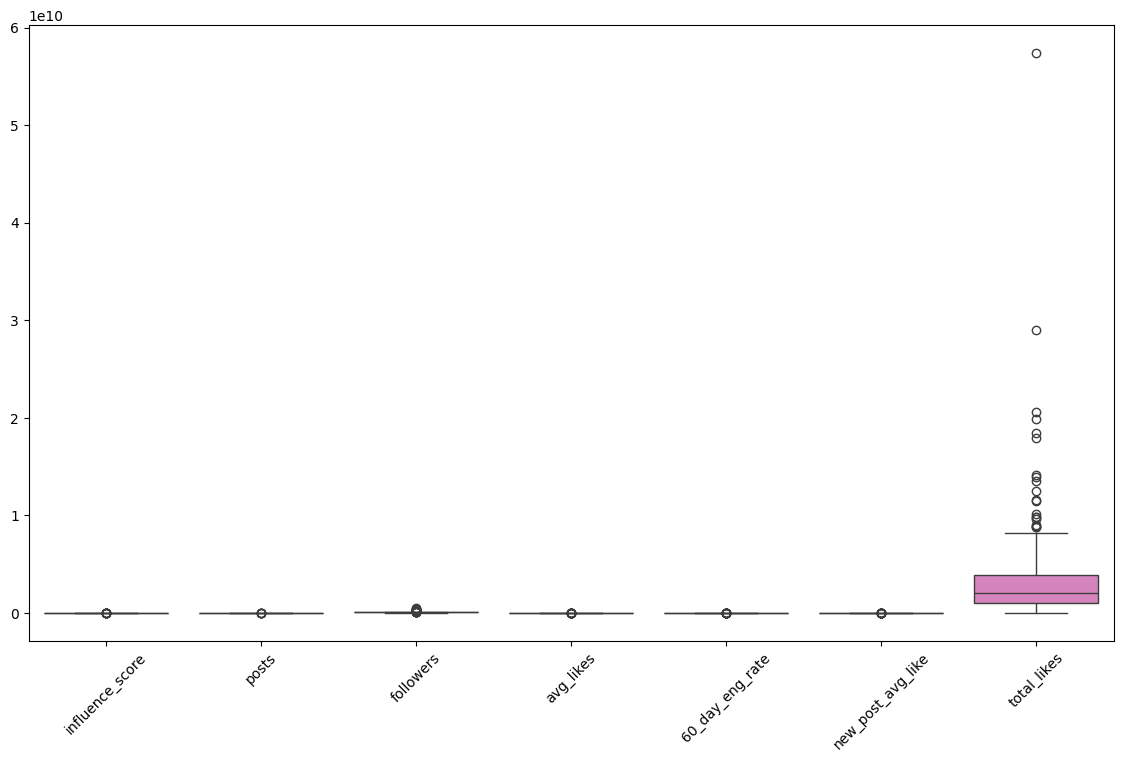

In [8]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=dataframe[['influence_score', 'posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes']])
plt.xticks(rotation=45)
plt.show()


Curiosamente, o Messi é o terceiro no rank, mas não se encontra nem no top 15 de curtidas, o que demonstra a quantidade de outliers nessa variável

In [9]:
top_15_likes = dataframe.nlargest(15, 'total_likes')
top_15_likes

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
1,2,kyliejenner,91,6900.0,366200000.0,8300000.0,0.0162,5900000.0,5.740000e+10
0,1,cristiano,92,3300.0,475800000.0,8700000.0,0.0139,6500000.0,2.900000e+10
22,23,zendaya,87,3500.0,150700000.0,5800000.0,0.0317,4800000.0,2.060000e+10
5,6,kimkardashian,91,5600.0,329200000.0,3500000.0,0.0088,2900000.0,1.990000e+10
6,7,arianagrande,92,5000.0,327700000.0,3700000.0,0.0120,3900000.0,1.840000e+10
25,26,badgalriri,88,4800.0,135300000.0,3700000.0,0.0002,0.0,1.790000e+10
19,20,neymarjr,90,5300.0,177100000.0,2700000.0,0.0109,1900000.0,1.410000e+10
9,10,justinbieber,91,7400.0,254500000.0,1900000.0,0.0059,1500000.0,1.390000e+10
16,17,nickiminaj,90,6400.0,201600000.0,2100000.0,0.0053,1000000.0,1.350000e+10
4,5,therock,91,6800.0,334100000.0,1900000.0,0.0020,665300.0,1.250000e+10


Com a análise de histogramas, percebemos algumas coisas

1. Obviamente o rank estará totalmente preenchido: temos um de cada de 200 a 1;
2. No influence score, existe uma grande concentração por volta de 85 pontos
3. Os dados concentram-se nas "quantidades menores", o seja, a maioria possui um perfil semelhante, e os outliers são sempre "para mais".



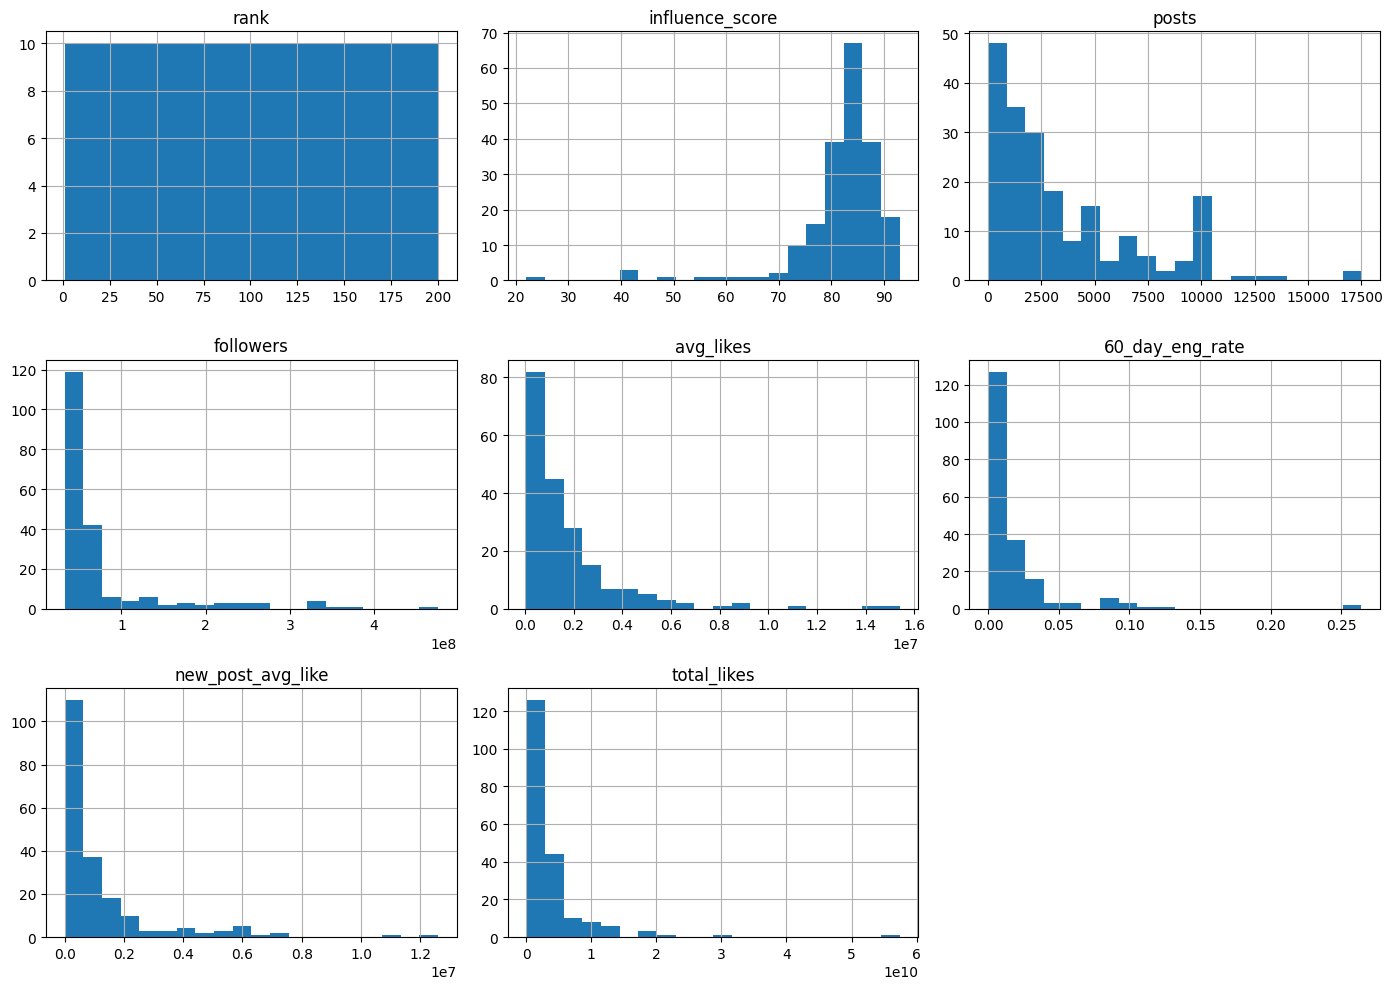

In [10]:
dataframe.hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

Remoção das variáveis categóricas reminescentes (o nome), para melhor análise estatística

In [11]:
dataframeNoName = dataframe.drop("channel_info",axis=1)

## Escolha da previsão após Matriz de Correlação
Após a verificação da correlação dos dados, percebe-se que new_post_avg_like aparenta estar mais relacionado que influence_score, o que tornaria uma modelo focado em sua regressão, mais eficiente. Portanto, focaremos nele.

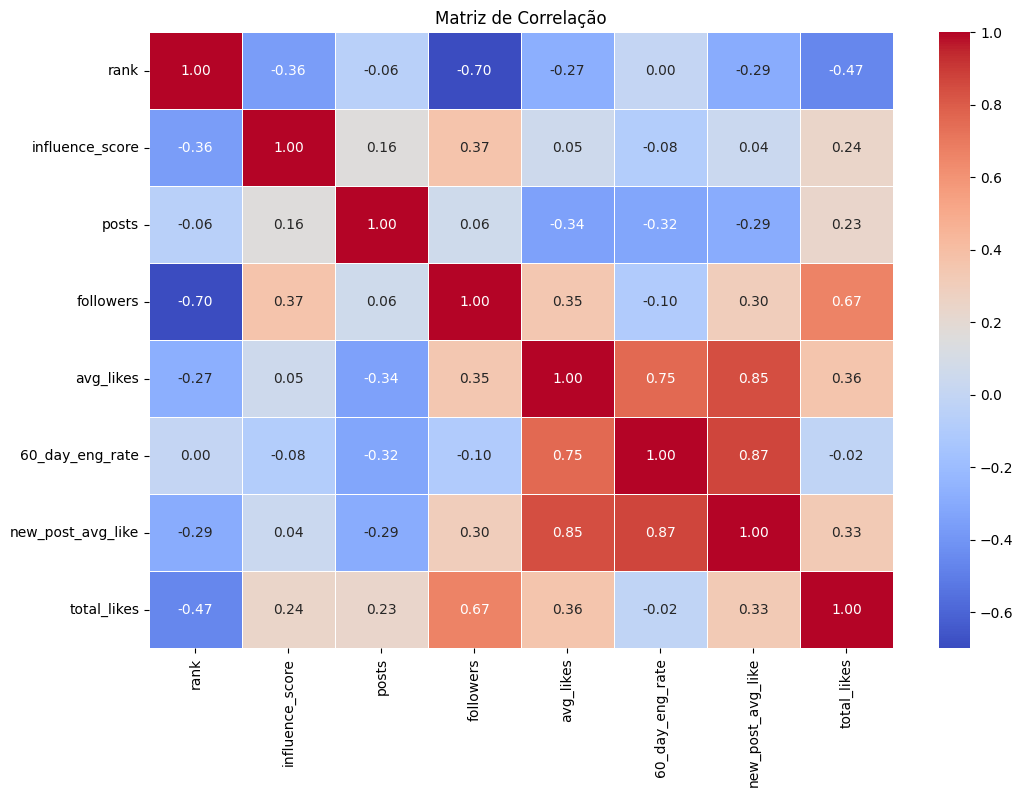

In [12]:
corr_matrix = dataframeNoName.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

Observando a relação de variáveis com a média de curtidas em pots novos, percebemos que há uma relação levemente linear, apesar da grande quantidade de outliers.

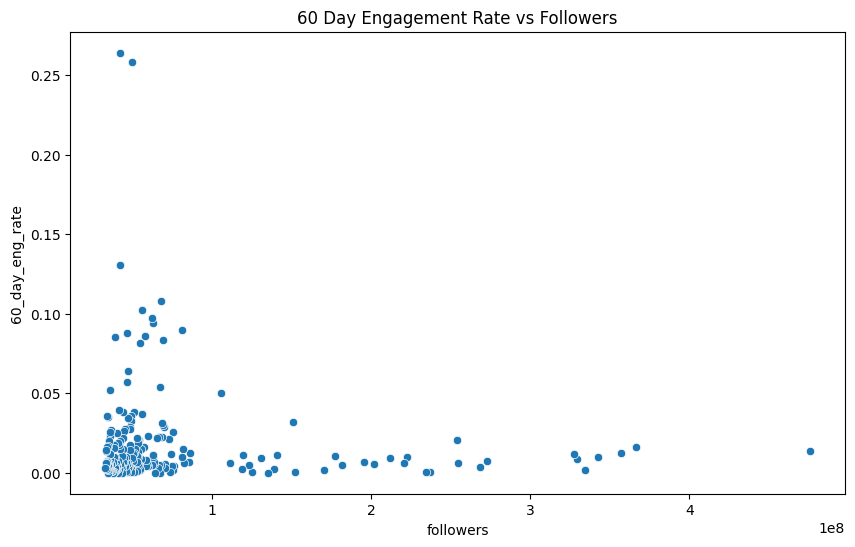

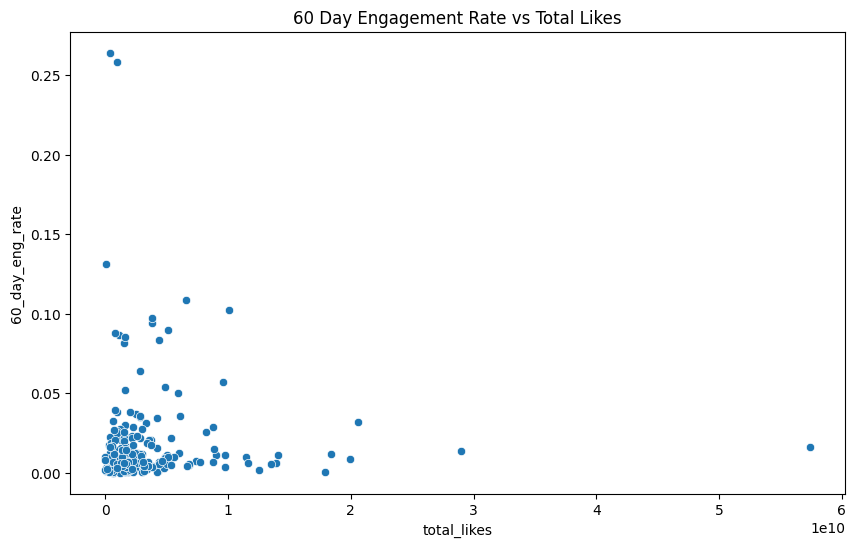

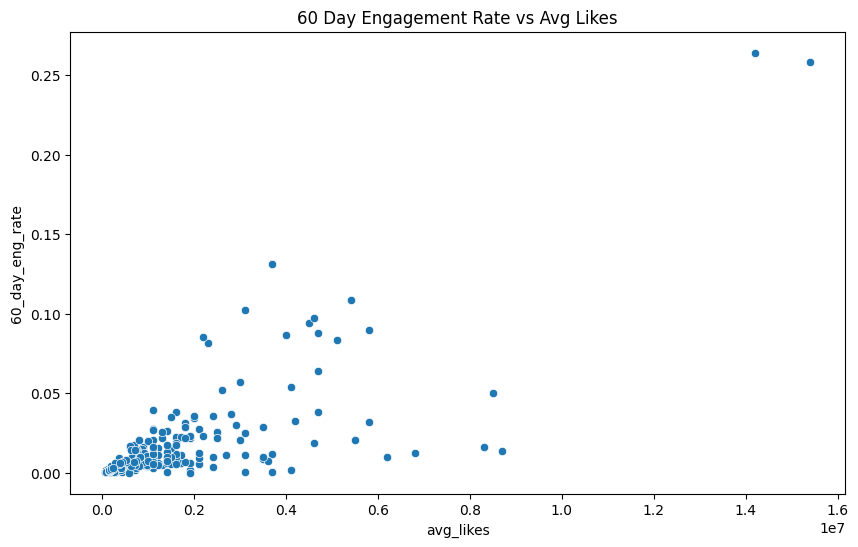

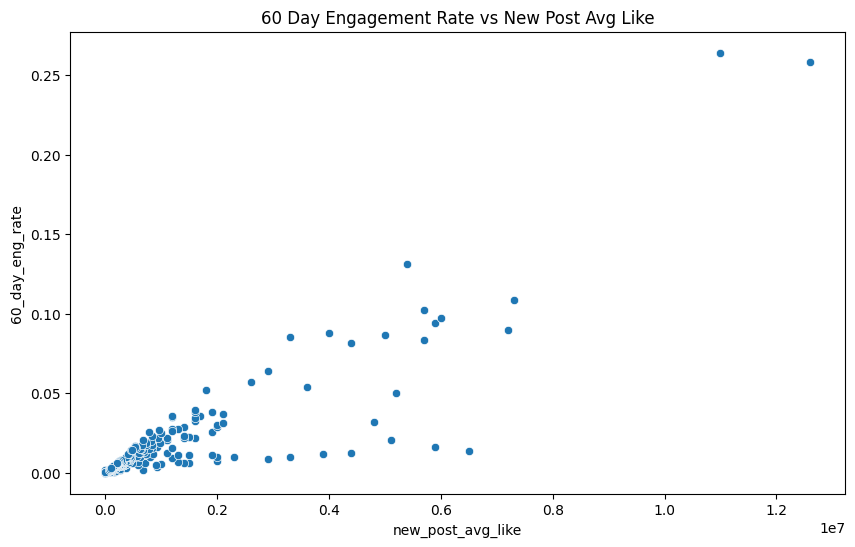

In [13]:
# Scatter plots para a relação entre `60_day_eng_rate` e outras variáveis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='followers', y='60_day_eng_rate', data=dataframe)
plt.title('60 Day Engagement Rate vs Followers')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_likes', y='60_day_eng_rate', data=dataframe)
plt.title('60 Day Engagement Rate vs Total Likes')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_likes', y='60_day_eng_rate', data=dataframe)
plt.title('60 Day Engagement Rate vs Avg Likes')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='new_post_avg_like', y='60_day_eng_rate', data=dataframe)
plt.title('60 Day Engagement Rate vs New Post Avg Like')
plt.show()


Analisamos os outliers, mas não removemos ainda pois queremos um treino preliminar

In [14]:
def identify_outliers_iqr(dataframe):
    # Seleciona apenas as colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns
    outliers = {}

    for column in numeric_columns:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1  # Intervalo interquartil

        lower_bound = Q1 - 2 * IQR
        upper_bound = Q3 + 2 * IQR

        # Identifica os outliers na coluna
        outliers[column] = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)][column]

        print(f"Coluna '{column}': {outliers[column].count()} outliers identificados")

    return outliers

outliers_dict = identify_outliers_iqr(dataframeNoName)

for column, outliers in outliers_dict.items():
    print(f"\nOutliers na coluna '{column}':\n", outliers.head())

Coluna 'rank': 0 outliers identificados
Coluna 'influence_score': 8 outliers identificados
Coluna 'posts': 3 outliers identificados
Coluna 'followers': 27 outliers identificados
Coluna 'avg_likes': 12 outliers identificados
Coluna '60_day_eng_rate': 16 outliers identificados
Coluna 'new_post_avg_like': 20 outliers identificados
Coluna 'total_likes': 15 outliers identificados

Outliers na coluna 'rank':
 Series([], Name: rank, dtype: int64)

Outliers na coluna 'influence_score':
 76     42
93     22
114    57
127    42
155    58
Name: influence_score, dtype: int64

Outliers na coluna 'posts':
 62     17500.0
123    16900.0
159    13400.0
Name: posts, dtype: float64

Outliers na coluna 'followers':
 0    475800000.0
1    366200000.0
2    357300000.0
3    342700000.0
4    334100000.0
Name: followers, dtype: float64

Outliers na coluna 'avg_likes':
 0     8700000.0
1     8300000.0
2     6800000.0
3     6200000.0
10    5500000.0
Name: avg_likes, dtype: float64

Outliers na coluna '60_day_en

## Modelagem Preliminar e sem ajuste
Primeiramente, treinaremos o modelo na maneira mais bruta possível: apenas removemos os NaNs e as variáveis não númericas (os nomes dos perfis). Não fizemos normalização e nem outras otimizações, pois queremos ver as métricas iniciais e assim decidir quais são os melhores caminhos a seguir.

In [15]:
dataframeNoName = dataframeNoName.dropna()

X = dataframeNoName.drop('60_day_eng_rate', axis=1)
y = dataframeNoName['60_day_eng_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.9240
MSE: 0.0000
MAE: 0.0050


As variáveis obtiveram coeficientes muito pequenos, incluindo avg_likes e new_post_avg_like, que têm grande correlação com o target. Isso se dá pela falta de normalização nessa tentativa inicial de treino do modelo.

In [16]:
coef = model.coef_
intercept = model.intercept_

# Associando os coeficientes aos nomes das variáveis
feature_names = X.columns
coef_df = pd.DataFrame(coef, index=feature_names, columns=['Coeficiente'])

print(f"Intercepto: {intercept:.4f}")
print("\nCoeficientes das variáveis independentes:")
print(coef_df)

Intercepto: -0.0090

Coeficientes das variáveis independentes:
                    Coeficiente
rank               1.767444e-05
influence_score    1.839266e-04
posts              5.596755e-07
followers         -1.396261e-10
avg_likes          2.634410e-09
new_post_avg_like  1.601358e-08
total_likes       -1.172911e-12


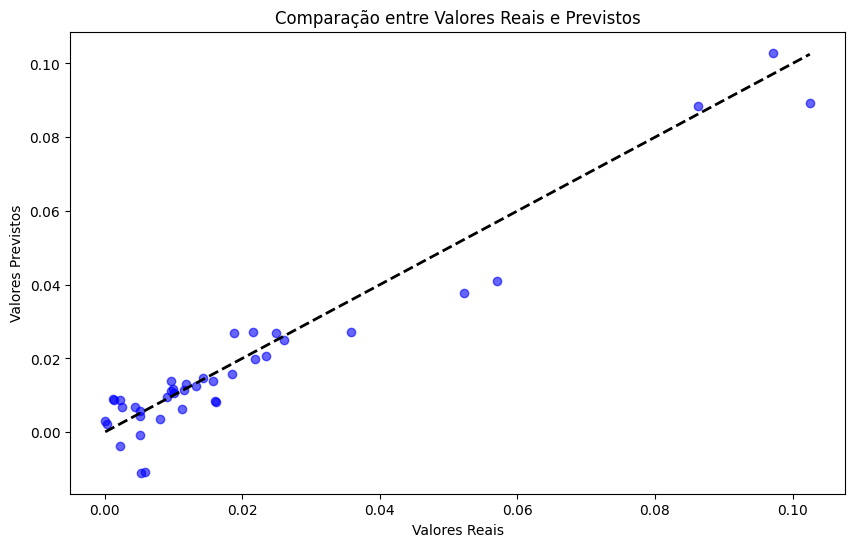

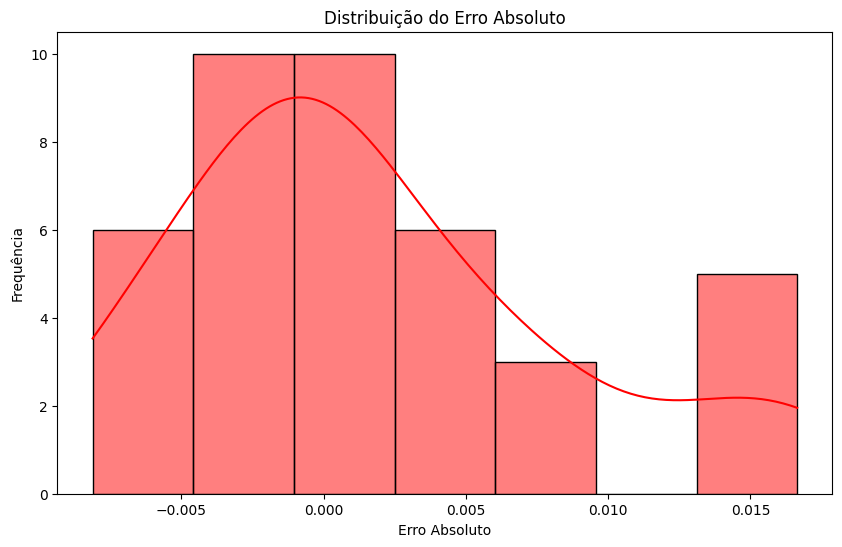

In [17]:
# Gráfico de dispersão entre os valores reais e as previsões
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Comparação entre Valores Reais e Previstos')
plt.show()

# Erro absoluto
error = y_test - y_pred

# Histograma do erro
plt.figure(figsize=(10, 6))
sns.histplot(error, kde=True, color='red')
plt.title('Distribuição do Erro Absoluto')
plt.xlabel('Erro Absoluto')
plt.ylabel('Frequência')
plt.show()

Curiosamente as métricas parecem boas, mas é sempre importante verificar por overfitting.

A análise de curva de aprendizado mostra um claro overfitting: a "curva" de treino é constante, enquanto que a de teste começa a decair por volta de 90 amostras. Faremos o tratamento de outliers

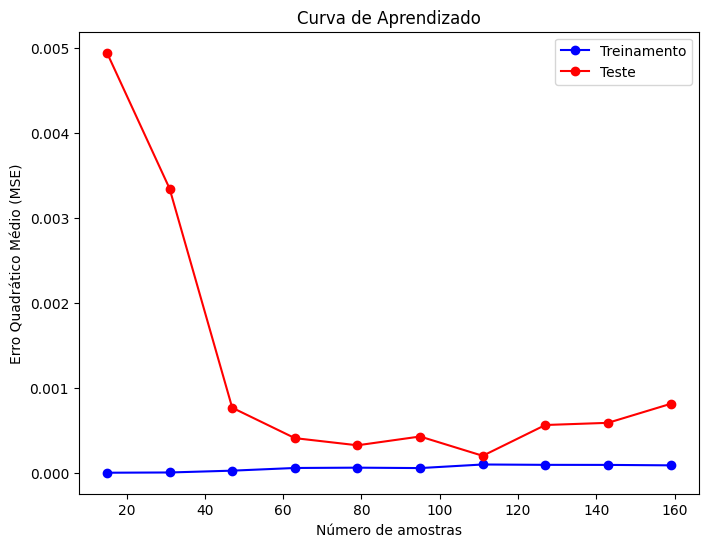

In [18]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5,scoring = 'neg_mean_squared_error',train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

#Deixando os valores "inversos" para melhor visualização
train_scores = -train_scores
test_scores = -test_scores

# Plotar as curvas
plt.figure(figsize = (8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Treinamento",color = 'blue',marker = 'o')
plt.plot(train_sizes, test_scores.mean(axis=1), label="Teste",color ='red',marker='o')
plt.xlabel("Número de amostras")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

In [19]:
# Previsões para o conjunto de teste
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# R² para treino e teste
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R² no treino: {r2_train}")
print(f"R² no teste: {r2_test}")

R² no treino: 0.9133513038875594
R² no teste: 0.9239893446167825


In [20]:
# Erros no treino e no teste
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"MSE no treino: {mse_train}")
print(f"MSE no teste: {mse_test}")
print(f"MAE no treino: {mae_train}")
print(f"MAE no teste: {mae_test}")

MSE no treino: 0.00010616780909708763
MSE no teste: 4.688147149891737e-05
MAE no treino: 0.006071526298688332
MAE no teste: 0.00502980490646089


In [21]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Scores de validação cruzada (MSE negativo): {cv_scores}")
print(f"Média dos scores de validação cruzada: {cv_scores.mean()}")

Scores de validação cruzada (MSE negativo): [-3.71072802e-03 -4.07329453e-05 -4.38289145e-05 -2.17163630e-04
 -3.89230645e-05]
Média dos scores de validação cruzada: -0.0008102753151423163


# 🤖 O MODELO FINAL
A partir de agora, as alterações fazem parte do modelo final, e o que deve ser avaliado como bem ou mal sucedido.

A "curva" de aprendizado e os outros parâmetros apontam um grande overfitting. Agora, melhoremos o modelo. Primeiramente, trateremos os dados com remoção de outliers e normalização.

In [22]:
def remove_outliers_iqr(dataframe, columns):
    """
    Remove outliers em cada coluna especificada do DataFrame com base no método IQR.
    """
    for column in columns:
        # Calcula o primeiro e terceiro quartis
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)

        # Calcula o IQR
        IQR = Q3 - Q1

        # Define os limites de detecção de outliers
        lower_bound = Q1 - 2 * IQR
        upper_bound = Q3 + 2 * IQR

        # Filtra os dados dentro dos limites
        dataframe = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

    return dataframe

# Aplicar a remoção de outliers para as colunas relevantes
colunas_com_outliers = ['rank', 'influence_score', 'posts', 'followers', 'avg_likes',
                         '60_day_eng_rate', 'new_post_avg_like', 'total_likes']
dataframeNoNameNoOut = remove_outliers_iqr(dataframeNoName, colunas_com_outliers)
dataframeNoNameNoOut

,rank,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
27,28,87,10000.0,125100000.0,420500.0,0.0007,81700.0,4.200000e+09
28,29,90,6900.0,123400000.0,996200.0,0.0048,588300.0,6.800000e+09
30,31,86,7300.0,118500000.0,463200.0,0.0022,255900.0,3.400000e+09
33,34,74,1300.0,85900000.0,2100000.0,0.0126,1100000.0,2.600000e+09
34,35,85,1700.0,85600000.0,1400000.0,0.0069,586500.0,2.300000e+09
...,...,...,...,...,...,...,...,...
195,196,71,2300.0,33200000.0,623800.0,0.0140,464700.0,1.400000e+09
196,197,81,3800.0,33200000.0,390400.0,0.0064,208000.0,1.500000e+09
197,198,79,770.0,33200000.0,193300.0,0.0026,82600.0,1.492000e+08
198,199,78,2300.0,33000000.0,719600.0,0.0142,467700.0,1.700000e+09


In [23]:
def normalize_data(dataframe, columns):
    """
    Normaliza as colunas especificadas usando Min-Max Scaling.
    """
    scaler = MinMaxScaler()
    dataframe[columns] = scaler.fit_transform(dataframe[columns])
    return dataframe

# Aplicar a normalização para as colunas relevantes
colunas_para_normalizar = ['rank', 'influence_score', 'posts', 'followers', 'avg_likes',
                        '60_day_eng_rate', 'new_post_avg_like', 'total_likes']
dataframeNoNameNoOut = normalize_data(dataframeNoNameNoOut, colunas_para_normalizar)
dataframeNoNameNoOut

,rank,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
27,0.000000,0.863636,0.745889,1.000000,0.117104,0.015152,0.04085,0.616615
28,0.005814,1.000000,0.514200,0.981582,0.306798,0.118687,0.29415,1.000000
30,0.017442,0.818182,0.544096,0.928494,0.131174,0.053030,0.12795,0.498651
33,0.034884,0.272727,0.095665,0.575298,0.670500,0.315657,0.55000,0.380686
34,0.040698,0.772727,0.125561,0.572048,0.439850,0.171717,0.29325,0.336450
...,...,...,...,...,...,...,...,...
195,0.976744,0.136364,0.170404,0.004334,0.184092,0.351010,0.23235,0.203739
196,0.982558,0.590909,0.282511,0.004334,0.107186,0.159091,0.10400,0.218485
197,0.988372,0.500000,0.056054,0.004334,0.042242,0.063131,0.04130,0.019302
198,0.994186,0.454545,0.170404,0.002167,0.215658,0.356061,0.23385,0.247976


## Adição de Valores artificiais para aumentar a base de dados
Aqui aumentamos a quantidade de amostras de maneira artificial, de modo que o modelo possa ter mais dados de treino. A remoção de outliers por meio da IQR remevou muitos dados. Também adicionamos um leve ruído para evitar overfitting

In [24]:
tamanho_original = len(dataframeNoNameNoOut)
quantidade_adicionada = int(tamanho_original * 0.5) #Adicionamos 50% mais amostras

# Criamos mais dados através da replicação de dados originais e a adição de ruído. O replace = false garante que o mesmo dado
# não será usado mais de uma vez, diminuindo o overfitting
dados_artificiais = dataframeNoNameNoOut.sample(n = quantidade_adicionada, replace = False)

fator_ruido = 0.03 # 3%

def add_ruido (df, fator_ruido):
  df_ruidoso = df.copy()
  for col in df.columns:
    ruido = np.random.normal(0,fator_ruido * df[col].std(),size = df.shape[0])
    df_ruidoso[col] = df[col] + ruido
  return df_ruidoso

# O ruído é adicionado nos dados replicados
dado_ruidoso_artificial = add_ruido(dados_artificiais, fator_ruido)

dataframe_expandido = pd.concat([dataframeNoNameNoOut,dado_ruidoso_artificial],axis = 0).reset_index(drop=True)
dataframe_expandido

,rank,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
0,0.000000,0.863636,0.745889,1.000000,0.117104,0.015152,0.040850,0.616615
1,0.005814,1.000000,0.514200,0.981582,0.306798,0.118687,0.294150,1.000000
2,0.017442,0.818182,0.544096,0.928494,0.131174,0.053030,0.127950,0.498651
3,0.034884,0.272727,0.095665,0.575298,0.670500,0.315657,0.550000,0.380686
4,0.040698,0.772727,0.125561,0.572048,0.439850,0.171717,0.293250,0.336450
...,...,...,...,...,...,...,...,...
194,0.410422,0.645732,0.173617,0.190714,0.049828,0.008020,0.010680,0.062780
195,0.818246,0.368937,0.018317,0.039797,0.045512,0.031448,0.016513,0.013343
196,0.935215,0.500130,0.696802,0.003437,0.048738,0.057660,0.044227,0.318395
197,0.888325,0.367614,0.066209,0.021365,0.233998,0.502851,0.327312,0.118358


## Aplicando PCA
Queremos reduzier a dimensão das amostras, então aplicaremos a PCA e verificaremos a variância explicada. Desejamos a menor quantidade possível

In [25]:
variaveis= dataframe_expandido.drop(columns = ['60_day_eng_rate'])

pca = PCA(n_components=5) # Queremos 5 variáveis

pca.fit(variaveis)

PCA(n_components=5)

Criação do DF após a PCA

In [26]:
# Transformando os dados no PCA
variaveis_pca = pca.transform(variaveis)

# Convertendo para um dataframe
pca_df = pd.DataFrame(variaveis_pca, columns=[f'PC{i+1}' for i in range(variaveis_pca.shape[1])])
pca_df

,PC1,PC2,PC3,PC4,PC5
0,-0.566390,0.922129,-0.080007,-0.056053,0.004930
1,-0.881452,0.710751,0.183805,0.105932,-0.160086
2,-0.556108,0.691856,-0.169766,-0.102829,0.042640
3,-0.706549,-0.180848,0.110559,-0.475305,0.138412
4,-0.594206,0.085939,-0.218362,-0.106925,-0.042666
...,...,...,...,...,...
194,0.154201,0.092238,-0.355370,-0.143656,0.002433
195,0.523135,-0.222755,-0.196039,-0.290678,-0.020100
196,0.607734,0.247681,0.261002,0.030012,0.072813
197,0.373992,-0.396719,0.062221,-0.165098,0.095041


Demonstração da variância explicada, para ver quais devemos manter

Variância explicada por componente: [0.41748252 0.29868655 0.12976551 0.06137749 0.04701575]
Variância explicada acumulada: [0.41748252 0.71616907 0.84593459 0.90731208 0.95432783]


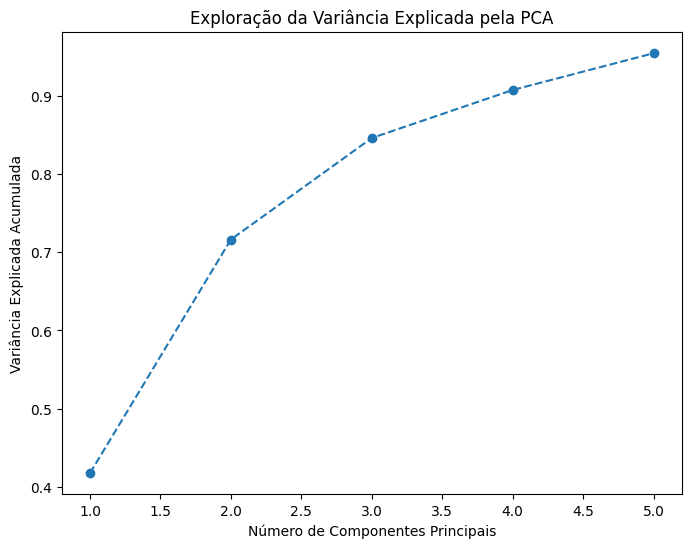

In [27]:
variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = variancia_explicada.cumsum()

print("Variância explicada por componente:", variancia_explicada)
print("Variância explicada acumulada:", variancia_acumulada)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(variancia_explicada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Exploração da Variância Explicada pela PCA')
plt.show()

4 componentes parece bom. Treinemos o modelo

In [28]:
# Variável dependente (target)
target = dataframe_expandido['60_day_eng_rate']

# Dados independentes após PCA
X = pca_df
y = target

# Dividindo os dados em treino e teste (80% treino e 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:

# Inicializando o modelo de regressão linear
modelo = LinearRegression()

# Treinando o modelo com os dados de treino
modelo.fit(X_train, y_train)

LinearRegression()

In [30]:
# Fazendo previsões com o conjunto de teste
y_pred = modelo.predict(X_test)

# Calculando as métricas de desempenho
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Exibindo as métricas
print(f"R² no teste: {r2}")
print(f"MSE no teste: {mse}")
print(f"MAE no teste: {mae}")

R² no teste: 0.8940145580303658
MSE no teste: 0.007267579992295889
MAE no teste: 0.05805191409669545


In [31]:
# Coeficientes das variáveis transformadas pela PCA
coeficientes = modelo.coef_

# Exibindo os coeficientes
for i, coef in enumerate(coeficientes):
    print(f"Coeficiente do PC{i+1}: {coef}")


Coeficiente do PC1: -0.22746460604244817
Coeficiente do PC2: -0.5045645508079889
Coeficiente do PC3: 0.36528312521612993
Coeficiente do PC4: 0.36223359041040715
Coeficiente do PC5: 0.6330115833888877


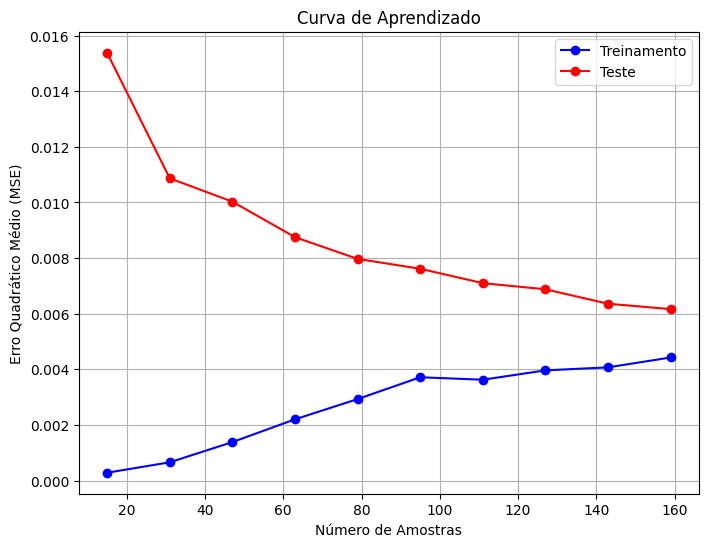

In [32]:
train_sizes, train_scores, test_scores = learning_curve(modelo, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

# Calculando a média e desvio padrão das pontuações de treino e teste
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

# Plotando as curvas de aprendizado
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Treinamento', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Teste', color='red', marker='o')
plt.xlabel('Número de Amostras')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.title('Curva de Aprendizado')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Métricas de desempenho nos dados de treino
y_train_pred = modelo.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Métricas de desempenho nos dados de teste
y_test_pred = modelo.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Exibindo as métricas
print(f"Métricas no Treinamento:")
print(f"R² no Treinamento: {train_r2}")
print(f"MSE no Treinamento: {train_mse}")
print(f"MAE no Treinamento: {train_mae}")

print(f"\nMétricas no Teste:")
print(f"R² no Teste: {test_r2}")
print(f"MSE no Teste: {test_mse}")
print(f"MAE no Teste: {test_mae}")

Métricas no Treinamento:
R² no Treinamento: 0.9225841111918214
MSE no Treinamento: 0.003940828359407658
MAE no Treinamento: 0.0449950352390021

Métricas no Teste:
R² no Teste: 0.8940145580303658
MSE no Teste: 0.007267579992295889
MAE no Teste: 0.05805191409669545


In [34]:
# Realizando a validação cruzada com 5 folds
scores = cross_val_score(modelo, X, y, cv=5, scoring='neg_mean_squared_error')

# Exibindo os resultados
print(f"Scores de Validação Cruzada (MSE): {scores}")
print(f"Média dos scores de validação cruzada: {-scores.mean()}")

Scores de Validação Cruzada (MSE): [-0.01046343 -0.00183571 -0.00756561 -0.00447442 -0.00648381]
Média dos scores de validação cruzada: 0.00616459665746078


O modelo parece bem próximo do original com uma PCA de 5 componentes. Avaliemos os resíduos para checar por Overfitting. Resíduos seguindo um padrão = forte indício de overfitting.

Os resíduos aparentam aleatórios, o que é benéfico para o modelo

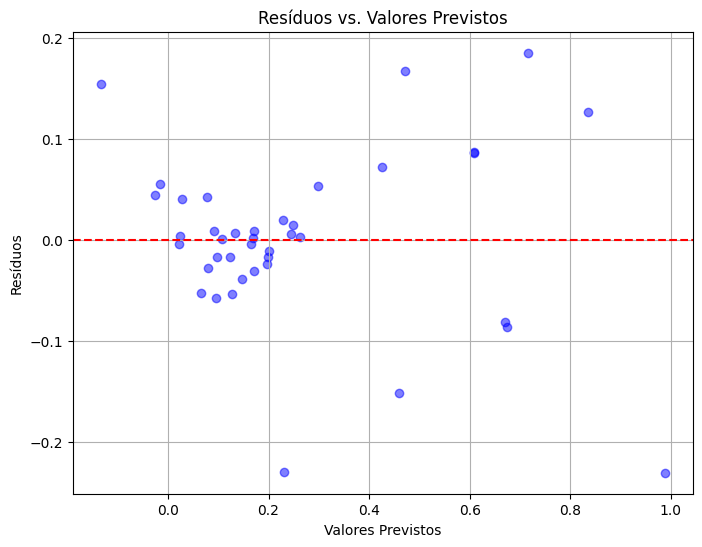

In [35]:
residuos = y_test - y_pred
# Gráfico de dispersão (Resíduos vs. Valores Previstos)
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuos, color='blue', marker='o', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Previstos')
plt.grid(True)
plt.show()

O histograma dos resíduos apresenta uma distribuição normal, com alguns outliers antes e depois. Novamente, é benéfico para o modelo.

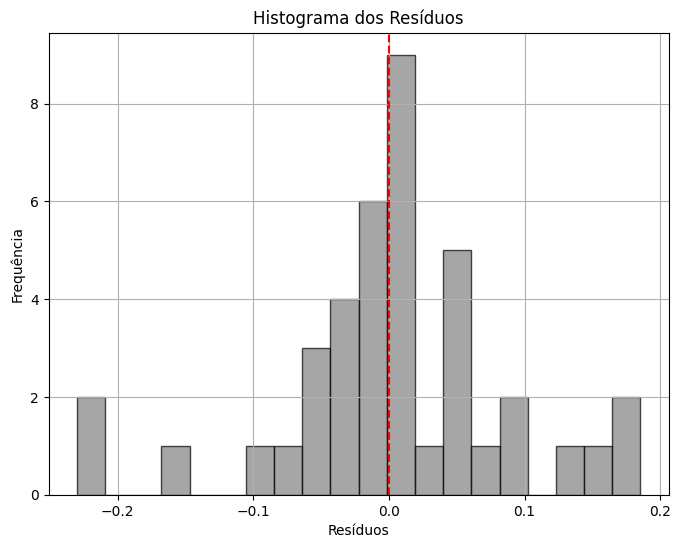

In [36]:
# Histograma dos resíduos
plt.figure(figsize=(8,6))
plt.hist(residuos, bins=20, color='gray', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Histograma dos Resíduos')
plt.grid(True)
plt.show()

Um gráfico Q-Q (Quantile-Quantile) é uma ferramenta poderosa para verificar se os resíduos de um modelo seguem uma distribuição normal, que é uma das suposições de muitos modelos estatísticos, incluindo a regressão linear.


- Linha Diagonal (45 graus): Representa onde os dados estariam se seguissem uma distribuição normal perfeitamente.

- Pontos no Gráfico: Representam os quantis dos resíduos.

  - Próximos da Linha: Se os pontos estão alinhados com a linha diagonal, isso indica que os resíduos seguem uma distribuição normal.

  - Fora da Linha: Se os pontos divergem significativamente da linha diagonal, especialmente nas caudas, isso indica que os resíduos não seguem uma distribuição normal.

  Nosso modelo aparenta estar próximo da distribuição normal, com outliers nos valores mais baixos

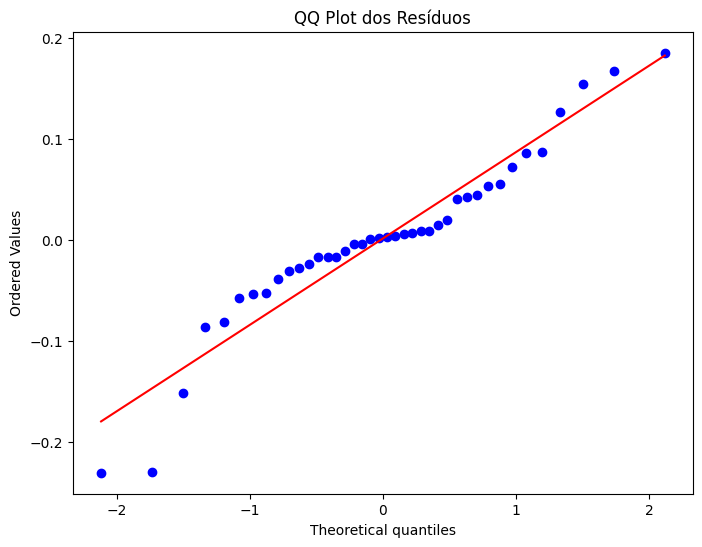

In [37]:
plt.figure(figsize=(8,6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('QQ Plot dos Resíduos')
plt.show()

O modelo aparenta estar balanceado. Agora, analisemos os coeficientes nas Componentes Principais, e vejamos quais variáveis são mais relevantes para o modelo

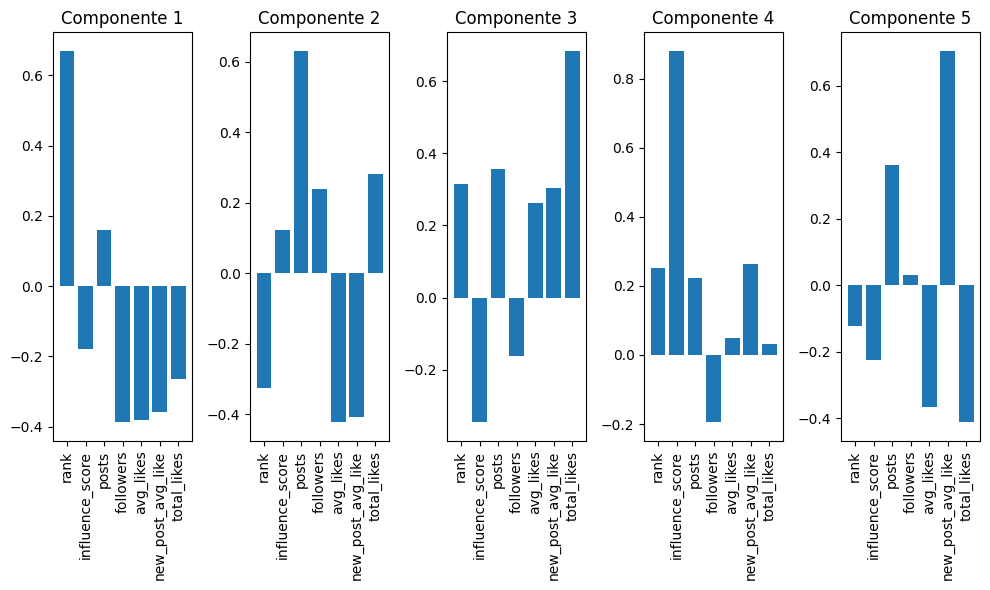

In [38]:
# Acessando os coeficientes (componentes principais)
componentes = pca.components_

# Nome das variáveis originais
variaveisG = variaveis.columns

# Plotando os coeficientes para cada componente
plt.figure(figsize=(10, 6))

# Número de componentes
n_componentes = componentes.shape[0]

for i in range(n_componentes):
    plt.subplot(1, n_componentes, i + 1)
    plt.bar(variaveisG, componentes[i])
    plt.title(f'Componente {i + 1}')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()

Componente 1: Popularidade e ranking geral.

Componente 2: Atividade (número de postagens) e posição no ranking.

Componente 3: Total de likes acumulados versus influência.

Componente 4: Influência como variável dominante.

Componente 5: Engajamento recente versus total de likes acumulados.

In [39]:
# Acessando os coeficientes (componentes principais)
componentes = pca.components_

# Nome das variáveis originais
variaveisT = variaveis.columns

# Exibindo os coeficientes das variáveis para cada componente
for i, componente in enumerate(componentes):
    print(f"Componente {i+1}:")
    for j, coeficiente in enumerate(componente):
        print(f"  {variaveisT[j]}: {coeficiente:.4f}")
    print("\n")


Componente 1:
  rank: 0.6693
  influence_score: -0.1783
  posts: 0.1590
  followers: -0.3884
  avg_likes: -0.3809
  new_post_avg_like: -0.3582
  total_likes: -0.2660


Componente 2:
  rank: -0.3255
  influence_score: 0.1218
  posts: 0.6309
  followers: 0.2392
  avg_likes: -0.4227
  new_post_avg_like: -0.4076
  total_likes: 0.2814


Componente 3:
  rank: 0.3134
  influence_score: -0.3462
  posts: 0.3569
  followers: -0.1610
  avg_likes: 0.2623
  new_post_avg_like: 0.3042
  total_likes: 0.6836


Componente 4:
  rank: 0.2506
  influence_score: 0.8807
  posts: 0.2234
  followers: -0.1955
  avg_likes: 0.0498
  new_post_avg_like: 0.2644
  total_likes: 0.0317


Componente 5:
  rank: -0.1227
  influence_score: -0.2258
  posts: 0.3618
  followers: 0.0322
  avg_likes: -0.3669
  new_post_avg_like: 0.7052
  total_likes: -0.4124




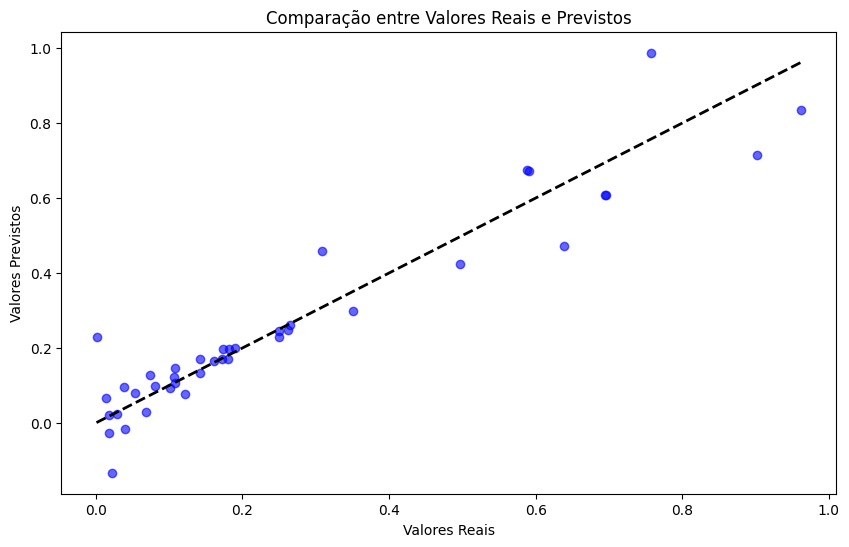

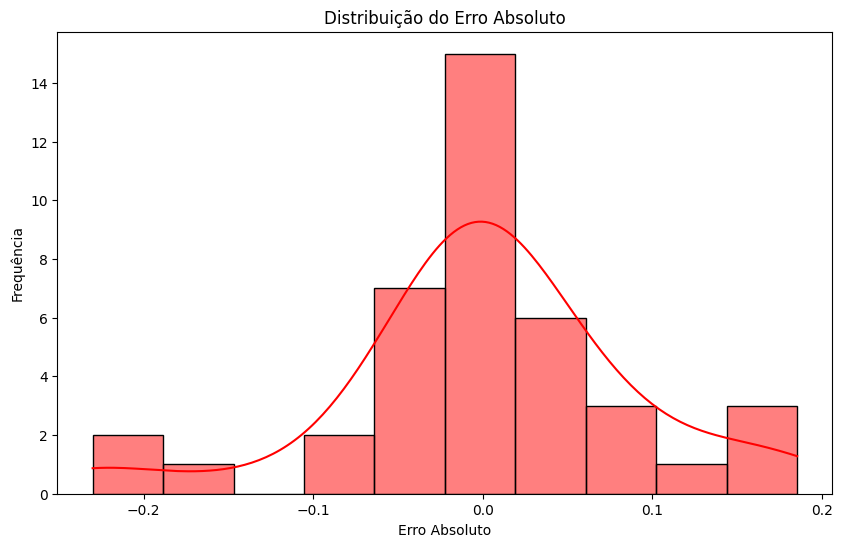

In [40]:
# Gráfico de dispersão entre os valores reais e as previsões
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Comparação entre Valores Reais e Previstos')
plt.show()

# Erro absoluto
error = y_test - y_pred

# Histograma do erro
plt.figure(figsize=(10, 6))
sns.histplot(error, kde=True, color='red')
plt.title('Distribuição do Erro Absoluto')
plt.xlabel('Erro Absoluto')
plt.ylabel('Frequência')
plt.show()